# Industrial Applications of Artificial Intelligence - Wind

### This notebook will give an overview on the datasets and algorithms that will be used for the first hand-in regarding the primary sector wind in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Due to excessive use of resources and climate change, the biggest challenge in human history will be the transformation of our way of living to a more considerate and mindful future. Renewable energies play a vital part in this transformation. Sources like wind, sund and water need to replace fossil materials coal and oil. Production can be improved if the plant operators are able to predict the predict natural forces and use them as efficient as possible. For this reason we will investigate different models for time series analysis of windspeed data. The dataset also contains a variety of different features. So, we want to explore if we can also predict the windspeed with classical algorithms.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import ipyparallel as ipp
import os
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from scipy.stats import boxcox
import warnings
from pmdarima import auto_arima

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

from platform import python_version
if python_version() < '3.8':
    import pickle5 as pickle
else:
    import pickle

In [3]:
def drop_correlated_features(df, thr=0.8):
    """
    Function to detect all correlated features
    :param df: general dataframe and threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

## 1. Import data

The dataset can be found on kaggle unter the following [url](https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting). In consists of 118.224 timestamps in the intervall between Jan 2018 to Mar 2020 of a wind turbine, at a 10 minute frequency. We will try to give a short explanation of the features in the following that have been collected by sensors. We see that we have a lot of NaNs in the dataset and have to cope with them.
* Timestamp: Timestamp of the dataset in 10 minute steps
* Active Power: Power that was produced by the turbine
* AmbientTemperature: Surrounding temperature of the system
* BearingShaftTemperature: Temperature of the shaft of the turbine
* Blade1PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 1
* Blade2PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 2
* Blade3PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 3
* ControlBoxTemperature: Temperature of the control box
* GearboxBearingTemperature: Temperature of the gearbox bearing		
* GearboxOilTemperature: Temperature of the gearbox oil		
* GeneratorRPM: Generator rotation speed
* GeneratorWinding1Temperature:	Temperature of generator winding 1
* GeneratorWinding2Temperature: Temperature of generator winding 1
* HubTemperature: Temperature of the hub		
* MainBoxTemperature: Temperature of the main box	
* NacellePosition: A nacelle is a cover housing that houses all of the generating components
* ReactivePower: idle power of the generator	
* RotorRPM:	Rotor rotation speed
* TurbineStatus: Status of the Turbine
* WTG: no further information, always the same value
* WindDirection: Cardinal direction the wind is coming from	
* WindSpeed: Wind speed, target variable

In [8]:
path = '../../src/data/Abgabe_1'

In [11]:
#import data
df_turbine = pd.read_csv(os.path.join(path, 'Turbine_Data.csv')).rename(columns={'Unnamed: 0':'timestamp'})
df_turbine.head(5)

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [15]:
type(df_turbine.timestamp[0])

str

In a first step we will transform the timestamp string into a datetime type to be able to better work with it.


In [20]:
df_turbine['timestamp'] = pd.to_datetime(df_turbine['timestamp'], format='%Y-%m-%d %H:%M:%S')

We will now reduce the dataset to only half-hourly measures by only keeping every third entry and reduce our set to around 40.000 entries.

In [29]:
df_turbine_filtered = df_turbine.iloc[::2, :].reset_index()

In [30]:
df_turbine_filtered

,index,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,6,2017-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,9,2017-12-31 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,12,2017-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,118209,2020-03-30 21:30:00+00:00,148.106791,27.599827,47.176703,0.692721,1.127439,1.127439,0.0,63.573022,...,65.372952,40.003815,38.583333,180.833333,29.205295,9.237732,2.0,G01,180.833333,4.458926
39404,118212,2020-03-30 22:00:00+00:00,186.146124,27.832195,46.656487,0.201022,0.635737,0.635737,0.0,62.980141,...,62.452566,39.992892,37.735635,187.250000,38.207072,9.234119,2.0,G01,187.250000,4.518272
39405,118215,2020-03-30 22:30:00+00:00,147.223697,27.577234,46.223171,0.633278,1.067585,1.067585,0.0,62.154613,...,60.651139,39.733410,37.210633,188.000000,29.910468,9.230950,2.0,G01,188.000000,4.190217
39406,118218,2020-03-30 23:00:00+00:00,90.331065,27.581193,45.819084,1.411808,1.846226,1.846226,0.0,60.275851,...,58.729390,39.010394,36.650659,178.000000,17.792888,9.235228,2.0,G01,178.000000,3.612339


We see that we have values at the beginning without windspeed data. We will discard the values in the beginning of the time series until we have a first measured windspeed. That leaves us with around 15.000 entries for WindSpeed.

In [40]:
# identify the rows with some NaN
s = df_turbine_filtered.notnull().all(1)

# remove those with NaN at beginning and at the end:
df_turbine_clean = df_turbine_filtered.loc[s.idxmax():s[::-1].idxmax()].reset_index()

In [42]:
df_turbine_clean.head(5)

,level_0,index,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,23597,70791,2019-05-06 14:30:00+00:00,-5.565284,39.206277,40.058399,41.260297,41.260230,41.260230,0.0,...,61.282616,40.253338,44.515622,49.00,-10.851533,0.508198,2.0,G01,49.00,2.130019
1,23598,70794,2019-05-06 15:00:00+00:00,-5.768376,38.992667,46.419196,47.399521,48.299502,48.299502,0.0,...,59.855694,46.004238,51.900000,93.25,-12.594477,0.550434,129.0,G01,93.25,2.161460
2,23599,70797,2019-05-06 15:30:00+00:00,-5.267268,38.847122,46.202435,33.397204,33.397196,33.397196,0.0,...,58.741532,46.003815,52.412475,NaN,-10.099696,0.801397,2.0,G01,NaN,2.323635
3,23600,70800,2019-05-06 16:00:00+00:00,-4.521693,38.993935,46.054246,NaN,NaN,NaN,0.0,...,57.722183,46.003815,52.569364,NaN,-9.770303,NaN,1.0,G01,NaN,1.740130
4,23601,70803,2019-05-06 16:30:00+00:00,-4.486592,38.913760,41.265172,85.000380,84.999664,84.999664,0.0,...,57.106857,41.403434,47.311922,77.00,-9.558695,NaN,485.0,G01,77.00,1.165717


In [43]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

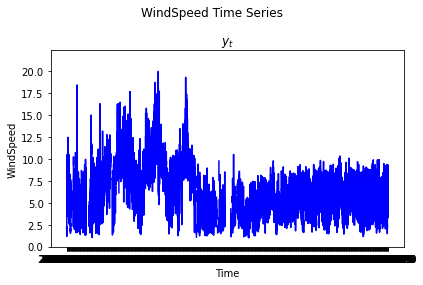

In [44]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

In [45]:
# look at distribution
df_turbine_clean.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
level_0,15811.00,31502.00,4564.39,23597.00,27549.50,31502.00,35454.50,39407.00
index,15811.00,94506.00,13693.16,70791.00,82648.50,94506.00,106363.50,118221.00
ActivePower,14152.00,674.98,630.01,-38.52,104.11,460.11,1243.48,1779.03
AmbientTemperatue,13855.00,28.34,4.06,19.36,25.39,27.82,31.05,41.81
BearingShaftTemperature,13879.00,43.22,5.52,0.00,39.94,42.97,47.48,55.07
Blade1PitchAngle,13993.00,9.71,20.59,-43.16,-0.94,0.41,8.06,90.14
Blade2PitchAngle,13941.00,10.02,20.24,-2.41,-0.43,0.91,8.48,90.02
Blade3PitchAngle,13941.00,10.02,20.24,-2.41,-0.43,0.91,8.48,90.02
ControlBoxTemperature,13812.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GearboxBearingTemperature,13886.00,64.75,10.77,0.00,58.52,65.39,71.80,82.24


### For a possible comparison to a feature based regression model, we will have a look at NaN values and correlated features.

In [ ]:
# we clearly see that we have a lot of NaN values inside our dataframe
df_turbine.isna().sum()

In [ ]:
# Fill numeric rows with the median
for label, content in df_turbine.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median since it's more robust than the mean
            df_turbine[label] = content.fillna(content.median())

In [ ]:
df_turbine

In [ ]:
# look at distribution
df_turbine.describe()

In [ ]:
# investigate correlation heatmap
corrMatrix=df_turbine.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [ ]:
#drop WTG feature since it is always the same value and windSpeed as target
df_target = df_turbine['WindSpeed']
#drop WTG and ControlBoxTemperature as they have always the same value in the whole column
df_turbine_cor = df_turbine.drop(columns=['WTG','WindSpeed','ControlBoxTemperature'])
# drop highly correlated features for a SVM baseline
df_turbine_cor = drop_correlated_features(df_turbine_cor)
# drop Blade3PitchAngle cause it has too much NaNs
df_turbine_cor = df_turbine_cor.drop(columns=['Blade3PitchAngle'])

In [ ]:
#attach windspeed again for further processing
df_turbine_cor = pd.concat([df_turbine_cor, df_target], axis = 1)
df_turbine_cor

### We have seen that we have a lot of correlated features. So, we dropped them to be able to use regression baselines like SVM.

In [ ]:
df_turbine_cor.isna().sum()

In [ ]:
y = df_turbine_cor['WindSpeed'].values
x = df_turbine_cor['timestamp'].values

In [ ]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

In [ ]:
# we select a promising subset out of the data by focusing on newer time intervalls, where data does not have to be imputed via mean 
input_df = df_turbine_cor[df_turbine_cor['timestamp'] > '2019-12-17 00:00:00+00:00']

In [ ]:
y = input_df['WindSpeed'].values
x = input_df['timestamp'].values

In [ ]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

### After searching for a promising subset, we have a look at the newest 15.000 data points.

In [ ]:
df_turbine_without_na = input_df

In [ ]:
df_turbine_without_na

### We take the first 1150 timestamps for training and  try to predict 50 steps. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#scale all features without WindSpeed
scale_features =['ActivePower','AmbientTemperatue','GeneratorWinding2Temperature','HubTemperature','MainBoxTemperature','ReactivePower','RotorRPM','TurbineStatus','WindDirection']
scaler = MinMaxScaler()
df_turbine_without_na[scale_features] = scaler.fit_transform(df_turbine_without_na[scale_features])

In [ ]:
# df_turbine_train = df_turbine_without_na[df_turbine_without_na['timestamp'] < '2020-03-01 00:00:00+00:00']
# df_turbine_test = df_turbine_without_na[df_turbine_without_na['timestamp'] >= '2020-03-01 00:00:00+00:00']

In [ ]:
df_turbine_train = df_turbine_without_na [:1150]
df_turbine_test = df_turbine_without_na[1150:1200]

In [ ]:
df_turbine_train

In [ ]:
df_turbine_test

In [ ]:
#generate split
data_train, target_train, data_test, target_test = df_turbine_train.drop(columns=['WindSpeed','timestamp']),df_turbine_train['WindSpeed'],df_turbine_test.drop(columns=['WindSpeed','timestamp']),df_turbine_test['WindSpeed']

In [ ]:
#rmse implementation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Compute a SVM and a random forest classification baseline for our data points to compare them to the values of ARIMA.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(data_train, target_train)
prediction = rf.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

In [ ]:
from sklearn.svm import SVR

sv_regressor = SVR(kernel = 'rbf')
sv_regressor.fit(data_train, target_train)
prediction = sv_regressor.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

### Try to improve by voting ensemble.

In [ ]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.svm import SVR

rf = RandomForestRegressor()
sv_regressor = SVR(kernel = 'rbf')

vo_reg = VotingRegressor([('rf', rf), ('svr', sv_regressor)])
vo_reg.fit(data_train, target_train)
prediction = vo_reg.predict(data_test)
rmse_score = rmse(prediction,target_test) 
print("The RMSE on test set: {:.4f}".format(rmse_score))

### Compute a naive baseline for time series data. We use the persistence algorithm. Use the value at the previous time step the predict the expected outcome at the next time step.

In [ ]:
# create a lagged representation for the train set to compute a supervised learning problem
values = pd.DataFrame(df_turbine_train['WindSpeed'].values)
df_train= pd.concat([values.shift(1), values], axis=1)
df_train.columns = ['t-1', 't+1']
#drop first row due to NaN
df_train = df_train.iloc[1:]
print(df_train.head(5))

In [ ]:
# create a lagged representation for the test set to compute a supervised learning problem
values = pd.DataFrame(df_turbine_test['WindSpeed'].values)
df_test = pd.concat([values.shift(1), values], axis=1)
df_test.columns = ['t-1', 't+1']
#input last value of train t+1 in t-1 test
df_test['t-1'][0] = df_train['t+1'].iloc[-1]
print(df_test.head(5))

In [ ]:
#split into input and target
train_X, train_y = df_train.values[:,0], df_train.values[:,1]
test_X, test_y = df_test.values[:,0], df_test.values[:,1]

In [ ]:
# persistence model to return actual input
def model_persistence(x):
    return x
#rmse implementation
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = rmse(predictions,test_y)
print('Test MSE: %.3f' % test_score)

In [ ]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

### We can clearly see from our test results that our distribution is already stationary and therefore needs no further preprocessing.

In [ ]:
y = df_turbine_without_na['WindSpeed'][:1200].values
x = df_turbine_without_na['timestamp'][:1200].values

In [ ]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
title += '\n ADF-test: {:.4f}.'.format(adfuller(y, regression='ctt')[1])
title += '\n KPSS-test: {:.4f}.'.format(kpss(y, regression='ct', nlags='auto')[1])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

###  ARIMA Selection - Initial Guesses for Autoregressive and Moving Average Order

In [ ]:
max_lag= 18
title = 'Without changes'
stld_plot = plot_acf(y, lags=range(1, max_lag+1),  title='ACF || '+ title)

In [ ]:
max_lag= 18
title = 'Without changes'
stld_plot = plot_pacf(y, lags=range(1, max_lag+1), title='PACF || ' + title)

### We can see that there is an PACF spike at LAG 1 -> initial guess: ARIMA (1,0,0)

In [ ]:
# helper function to evaluate a SARIMA model

def eval_sarima(order, seasonal_order, y, n_train, transform=None, inverse_transform=None):
    """
    Evaluate the model SARIMA(order, seasonal_order) on the target y in a one-step ahead prediction fashion.
    
    Parameters
    ----------
    order: 3-tuple
        (p, d, q), specifying the ARIMA parameters
    seasonal_order: 4-tuple
        (P, D, Q, m), specifying the seasonal parameters
    y: np.array(n,)
        target
    n_train: int
        Min. training size. For t=0, ..., len(y)-n_train-1, the SARIMA model is fit on y[:n_train+t] and evaluated on
        y[n_train+t].
    transform: callable, optional
        Transformation function applied to y before model is fit.
    inverse_transform: callable, optional (must be specified if transform is not None)
        Inverse of transformation function. Applied to predictions to ensure the error is computed in the rigt scale.
    """
    
    
    y_transf = transform(y) if transform is not None else y
    inverse_transform = inverse_transform if inverse_transform is not None else lambda x: x
    preds = []
        
    try:
        for t in range(n_train, len(y)):
            model = ARIMA(y_transf[:t], order=order, seasonal_order=seasonal_order)
            model = model.fit()
            preds.append(inverse_transform(model.forecast().item()))
        preds = np.array(preds)
        rmse = np.sqrt( np.mean( (y[n_train:]-preds)**2 ) )
        msg = 'Success'
        
    except Exception as e:
        msg = e
        rmse = np.nan
        preds = np.array(preds)
        
    return rmse, preds, msg

In [ ]:
# helper function to visualize the results of a SARIMA gridsearch

def vis_comp(savefig, path, suptitle):
    """
    Visualizes results of a SARIMA gridsearch in comparison to some naive baselines.
    
    Parameters:
    ----------
    savefig: boolean
        Whether to save the resulting figure.
    path: string
        Where to load the results from that are to be visualized. If savefig is True, figure is saved to 'Image/' + path
    path: string
        ARIMA or SARIMA
    """

    # load best models for transformed and original data
    results = load_obj('', path)
    (order_transf, (_, preds_transf, _)) = min(results['bc'].items(), key=lambda x: x[1][0])
    (order_notransf, (_, preds_notransf, _)) = min(results['none'].items(), key=lambda x: x[1][0])

    # some naive baselines to contextualize model performance
    y_preds_naive = y[int(len(df_turbine_train))-1:-1]
    y_preds_snaive = y[int(len(df_turbine_train))-12:-12]

    # visualize results
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(ncols, nrows, figsize=(14, 10))
    model_title = 'SARIMA(({},{},{})({},{},{},{}))' if suptitle=='SARIMA' else 'ARIMA({},{},{})'
    for n_plot, (y_preds, method) in enumerate([(y_preds_naive, 'Naive'), (y_preds_snaive, 'Seasonal Naive'),
                                (preds_transf, model_title.format(*order_transf) + '[bct(y)]'),
                                (preds_notransf, model_title.format(*order_transf) + '[y]')]):

        # compute errors (rmse and mape)
        rmse = np.sqrt( np.mean( (y_preds-y[int(len(df_turbine_train)):])**2 ) )
        mape = np.mean( abs(y_preds-y[int(len(df_turbine_train)):])/y[int(len(df_turbine_train)):] )*100

        # plot actuals and predictions
        ax = axes[n_plot//ncols, n_plot%ncols]
        ax.plot(y, color='b', label='actual')
        ax.plot(range(int(len(df_turbine_train)), len(y)), y_preds, ls='--', color='orange', label='prediction')
        ax.set_title('{}. RMSE={:.2f}. MAPE={:.2f}%.'.format(method, rmse, mape))

    fig.suptitle('RMSE-optimal ARIMA models with and without transformation vs. naive baselines.'.format(suptitle))
    fig.tight_layout()
    if savefig:
        fig.savefig(r'Images/' + path)

In [ ]:
def save_obj(obj, path, name):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save=True
saveto=r'results_initialguess_arima'

order_ls = [(1,0,0)]
min_rmse = np.inf
results = {}
results['bc'] = {}
for order in tqdm(order_ls):
    rmse, preds, msg = eval_sarima(order=order, seasonal_order=(0,0,0,0), y=y, n_train=int(len(df_turbine_train)))
    results['bc'][order] = (rmse, preds, msg)

if save:
    save_obj(results, '', saveto)

In [ ]:
save=True
saveto=r'results_initialguess_arima'

order_ls = [(1,0,0)]
results = {}
for (preprocess, transform, inverse_transform) in [('bc', None, None), ('none', None, None)]:
    min_rmse = np.inf
    results[preprocess] = {}
    for order in tqdm(order_ls):
        rmse, preds, msg = eval_sarima(order=order, seasonal_order=(0,0,0,0), y=y, n_train=int(len(df_turbine_train)))
        results[preprocess][order] = (rmse, preds, msg)

if save:
    save_obj(results, '', saveto)

In [ ]:
vis_comp(savefig=True, path='results_initialguess_arima', suptitle='ARIMA')

In [ ]:
results

In [ ]:
#import data
df_wind = pd.read_csv(os.path.join(path, 'germany-wind-energy.csv'))
df_wind

In [ ]:
#import data
df_all = pd.read_csv(os.path.join(path, 'all_energy_statistics.csv'))
df_all